In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from glmnet import LogitNet

from mlxtend.classifier import EnsembleVoteClassifier

In [3]:
from vecstack import stacking

In [4]:
churn_df = pd.read_csv("../data/churn_train.csv")
X = churn_df.drop(['churn_label'], axis=1)
y = churn_df.churn_label

In [5]:
print X.shape, y.shape

(572171, 21) (572171,)


In [6]:
RANDOM_SEED = 24
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = RANDOM_SEED
)

### mlxtend ensemble vote

In [8]:
clf_rf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=2, n_estimators=300)
clf_xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=186,
    max_depth=7,
    min_child_weight=5,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    reg_lambda=10,
    n_jobs=2,
    random_state=RANDOM_SEED)

clf_lg = LogitNet(n_splits=5, scoring='roc_auc', n_jobs=2, random_state=RANDOM_SEED)

models = [clf_rf, clf_xgb, clf_lg]

In [9]:
%%time
for clf in models:
    clf.fit(X_train, y_train)

CPU times: user 11min 11s, sys: 8.89 s, total: 11min 20s
Wall time: 5min 58s


In [23]:
%%time
eclf = EnsembleVoteClassifier(clfs=models, weights=[1,1,1], refit=False, voting='soft')
eclf.fit(X_train, y_train)

CPU times: user 9.49 ms, sys: 3.34 ms, total: 12.8 ms
Wall time: 11.4 ms


In [24]:
%%time
test_predprob_rf = clf_rf.predict_proba(X_test)[:, 1]
test_prediction_rf = clf_rf.predict(X_test)

test_predprob_xgb = clf_xgb.predict_proba(X_test)[:,1]
test_prediction_xgb = clf_xgb.predict(X_test)

test_predprob_lg = clf_lg.predict_proba(X_test)[:, 1]
test_prediction_lg = clf_lg.predict(X_test)

test_predprob_ev = eclf.predict_proba(X_test)[:, 1]
test_prediction_ev = eclf.predict(X_test)

CPU times: user 1min 14s, sys: 749 ms, total: 1min 15s
Wall time: 39.1 s


In [25]:
print "AUC Score (Test): for randomforest {}".format(metrics.roc_auc_score(y_test, test_predprob_rf))
print "AUC Score (Test): for xgboost {}".format(metrics.roc_auc_score(y_test, test_predprob_xgb))
print "AUC Score (Test): for logistic regression {}".format(metrics.roc_auc_score(y_test, test_predprob_lg))
print "AUC Score (Test): for ensemble vote {}".format(metrics.roc_auc_score(y_test, test_predprob_ev))

print "Accuracy (Test) for randomforest: {}".format(metrics.accuracy_score(y_test, test_prediction_rf))
print "Accuracy (Test) for xgboost: {}".format(metrics.accuracy_score(y_test, test_prediction_xgb))
print "Accuracy (Test) for logistic regression: {}".format(metrics.accuracy_score(y_test, test_prediction_lg))
print "Accuracy (Test) for ensemble vote: {}".format(metrics.accuracy_score(y_test, test_prediction_ev))

AUC Score (Test): for randomforest 0.904000972985
AUC Score (Test): for xgboost 0.910165814658
AUC Score (Test): for logistic regression 0.897334762279
AUC Score (Test): for ensemble vote 0.90821643158
Accuracy (Test) for randomforest: 0.842609341548
Accuracy (Test) for xgboost: 0.84681260104
Accuracy (Test) for logistic regression: 0.830742342815
Accuracy (Test) for ensemble vote: 0.846122252807


### vecstack model stacking

In [29]:
clf_rf2 = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=2, n_estimators=300)

clf_xgb2 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=186,
    max_depth=7,
    min_child_weight=5,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    reg_lambda=10,
    n_jobs=2,
    random_state=RANDOM_SEED)

clf_lg2 = LogitNet(n_splits=5, scoring='roc_auc', n_jobs=2, random_state=RANDOM_SEED)

models_2 = [clf_rf2, clf_xgb2, clf_lg2]

In [35]:
%%time
# Compute stacking features
S_train, S_test = stacking(models_2, X_train.values, y_train.values, X_test.values, 
                           regression=False, metric=metrics.roc_auc_score, n_folds=3, 
                           random_state=RANDOM_SEED, verbose=2)

task:   [classification]
metric: [roc_auc_score]

model 0: [RandomForestClassifier]
    fold 0: [0.81770003]
    fold 1: [0.81775992]
    fold 2: [0.81730449]
    ----
    MEAN:   [0.81759310]

model 1: [XGBClassifier]
    fold 0: [0.81943191]
    fold 1: [0.81855385]
    fold 2: [0.81807644]
    ----
    MEAN:   [0.81869259]

model 2: [LogitNet]
    fold 0: [0.81912397]
    fold 1: [0.81808698]
    fold 2: [0.81838491]
    ----
    MEAN:   [0.81853304]

CPU times: user 21min 50s, sys: 23.2 s, total: 22min 13s
Wall time: 11min 54s


In [43]:
%%time
# Initialize 2-nd level model
model_level_2 = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=2, n_estimators=300)
    
# Fit 2-nd level model
model_level_2.fit(S_train, y_train)

CPU times: user 27.4 s, sys: 3.18 s, total: 30.6 s
Wall time: 16.4 s


In [44]:
test_predprob_sk = model_level_2.predict_proba(S_test)[:, 1]

In [45]:
print "AUC Score (Test): for stacking {}".format(metrics.roc_auc_score(y_test, test_predprob_sk))

AUC Score (Test): for stacking 0.84254513723


In [46]:
np.unique(S_train)
# it could not produce probablity...

array([ 0.,  1.])

### mlxtend model stacking

In [54]:
from mlxtend.classifier import StackingCVClassifier

In [63]:
clf_rf3 = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=2, n_estimators=300)

clf_xgb3 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=186,
    max_depth=7,
    min_child_weight=5,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    reg_lambda=10,
    n_jobs=2,
    random_state=RANDOM_SEED)

clf_lg3 = LogitNet(n_splits=5, scoring='roc_auc', n_jobs=2, random_state=RANDOM_SEED)

clf_level_2_rf = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=2, n_estimators=300)

# The StackingCVClassifier uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior
np.random.seed(RANDOM_SEED)
sclf = StackingCVClassifier(classifiers=[clf_rf3, clf_xgb3, clf_lg3], meta_classifier=clf_level_2_rf,
                            verbose=2, use_probas=True, cv=3)

In [65]:
%%time
sclf.fit(X_train.values, y_train.values)

Fitting 3 classifiers...
Fitting classifier1: randomforestclassifier (1/3)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
            oob_score=False, random_state=24, verbose=0, warm_start=False)
Training and fitting fold 1 of 3...
Training and fitting fold 2 of 3...
Training and fitting fold 3 of 3...
Fitting classifier2: xgbclassifier (2/3)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=186,
       n_jobs=2, nthread=None, objective='binary:logistic',
       random_state=24, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
       seed=None, si

StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_f...   n_splits=5, random_state=24, scoring='roc_auc', standardize=True,
     tol=1e-07, verbose=False)],
           cv=3,
           meta_classifier=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
            oob_score=False, random_state=24, verbose=0, warm_start=False),
           shuffle=True, stratify=True, use_features_in_secondary=False,
           use_probas=True, verbose=2)

In [66]:
test_prediction_sclf = sclf.predict(X_test.values)
test_predprob_sclf = sclf.predict_proba(X_test.values)[:, 1]

In [67]:
print "AUC Score (Test): for randomforest {}".format(metrics.roc_auc_score(y_test, test_predprob_rf))
print "AUC Score (Test): for xgboost {}".format(metrics.roc_auc_score(y_test, test_predprob_xgb))
print "AUC Score (Test): for logistic regression {}".format(metrics.roc_auc_score(y_test, test_predprob_lg))
print "AUC Score (Test): for ensemble vote {}".format(metrics.roc_auc_score(y_test, test_predprob_ev))
print "AUC Score (Test): for stacking {}".format(metrics.roc_auc_score(y_test, test_predprob_sclf))

print "Accuracy (Test) for randomforest: {}".format(metrics.accuracy_score(y_test, test_prediction_rf))
print "Accuracy (Test) for xgboost: {}".format(metrics.accuracy_score(y_test, test_prediction_xgb))
print "Accuracy (Test) for logistic regression: {}".format(metrics.accuracy_score(y_test, test_prediction_lg))
print "Accuracy (Test) for ensemble vote: {}".format(metrics.accuracy_score(y_test, test_prediction_ev))
print "Accuracy (Test) for stacking: {}".format(metrics.accuracy_score(y_test, test_prediction_sclf))

AUC Score (Test): for randomforest 0.904000972985
AUC Score (Test): for xgboost 0.910165814658
AUC Score (Test): for logistic regression 0.897334762279
AUC Score (Test): for ensemble vote 0.90821643158
AUC Score (Test): for stacking 0.89511394605
Accuracy (Test) for randomforest: 0.842609341548
Accuracy (Test) for xgboost: 0.84681260104
Accuracy (Test) for logistic regression: 0.830742342815
Accuracy (Test) for ensemble vote: 0.846122252807
Accuracy (Test) for stacking: 0.832734740246


## Plot

In [114]:
import seaborn as sns
sns.set_style('whitegrid')

### random forest

In [76]:
feat_imp_df_rf = pd.DataFrame({'feature': X_train.columns, 'feature_importance_score': clf_rf.feature_importances_})
feat_imp_df_rf = feat_imp_df_rf.sort_values('feature_importance_score', ascending=False)

/Users/Meng/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


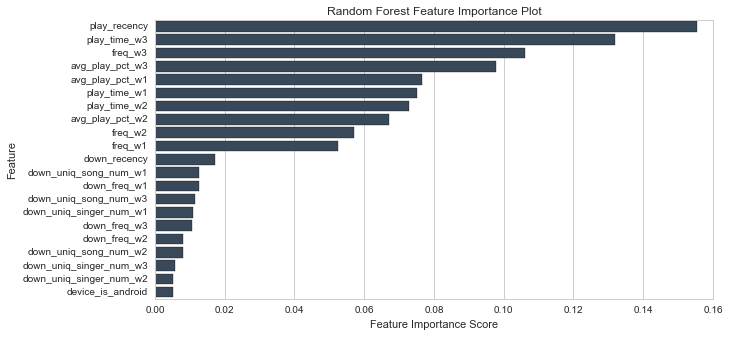

In [116]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
sns.barplot(x='feature_importance_score', y='feature', data=feat_imp_df_rf, color="#34495e", ax=ax)
ax.set(xlabel='Feature Importance Score', ylabel='Feature')
ax.set_title('Random Forest Feature Importance Plot')
fig.savefig("../demo_day/rf_fimp.png")

### xgboost

In [83]:
feat_imp_df_xgb = pd.Series(clf_xgb.get_booster().get_score(importance_type='gain')).\
sort_values(ascending=False).reset_index()
feat_imp_df_xgb.columns = ['feature', 'feature_importance_score']

/Users/Meng/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


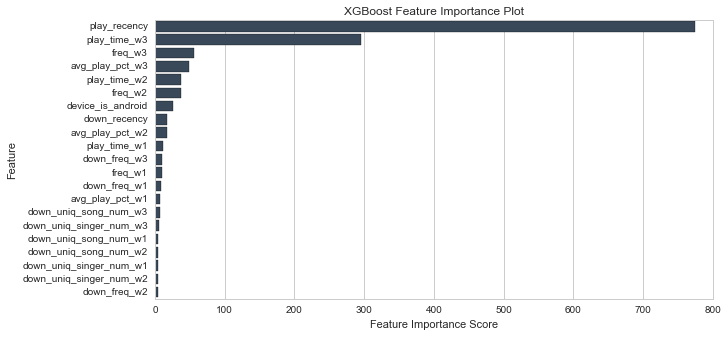

In [120]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
sns.barplot(x='feature_importance_score', y='feature', data=feat_imp_df_xgb, color="#34495e", ax=ax)
ax.set(xlabel='Feature Importance Score', ylabel='Feature')
ax.set_title('XGBoost Feature Importance Plot')
fig.savefig("../demo_day/xgb_fimp.png")

In [85]:
feat_imp_df_xgb2 = pd.Series(clf_xgb.get_booster().get_score(importance_type='weight')).\
sort_values(ascending=False).reset_index()
feat_imp_df_xgb2.columns = ['feature', 'feature_importance_score']

/Users/Meng/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


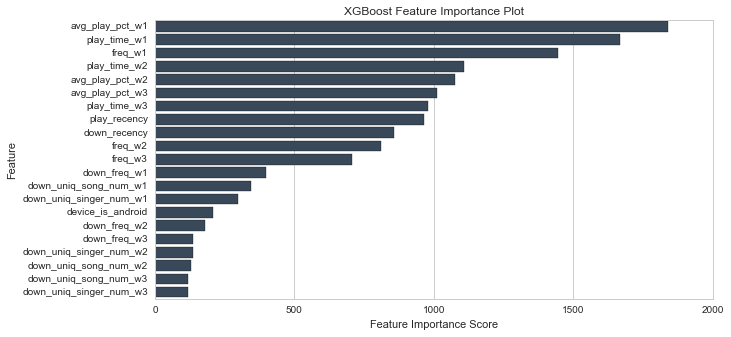

In [121]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
sns.barplot(x='feature_importance_score', y='feature', data=feat_imp_df_xgb2, color="#34495e", ax=ax)
ax.set(xlabel='Feature Importance Score', ylabel='Feature')
ax.set_title('XGBoost Feature Importance Plot')
fig.savefig("../demo_day/xgb_fimp2.png")

In [90]:
coef_df_lasso = pd.DataFrame({'feature': X_train.columns, 'coef': clf_lg.coef_.flatten()}).\
sort_values('coef', ascending=False)

/Users/Meng/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


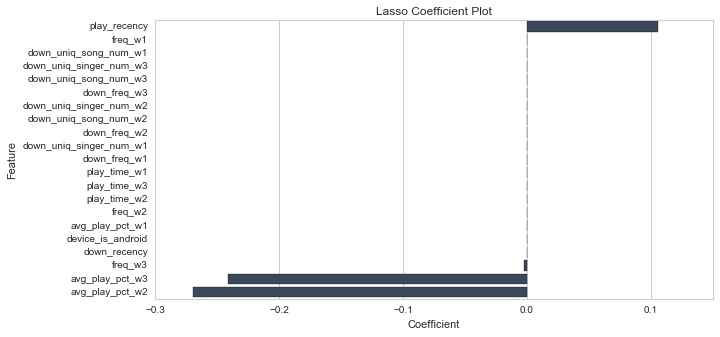

In [122]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
sns.barplot(x='coef', y='feature', data=coef_df_lasso, color="#34495e", ax=ax)
ax.set(xlabel='Coefficient', ylabel='Feature')
ax.set_title('Lasso Coefficient Plot')
fig.savefig("../demo_day/lasso_coef.png")

### roc curve

In [98]:
roc_dict = {}
models_5 = [clf_rf, clf_xgb, clf_lg, eclf, sclf]
labels = ['random forest', 'xgboost', 'lasso logistic', 'ensemble voting', 'cv stacking']
i = 1
for lb, md in zip(labels, models_5):
    print i
    try:
        test_predprob = md.predict_proba(X_test)[:, 1]
    except:
        test_predprob = md.predict_proba(X_test.values)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, test_predprob)
    auc = metrics.roc_auc_score(y_test, test_predprob)
    roc_dict[lb] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}
    i+=1

1
2
3
4
5


In [99]:
tmp = {'a': 1, 'b': 2}

In [124]:
sns.set_style('ticks')

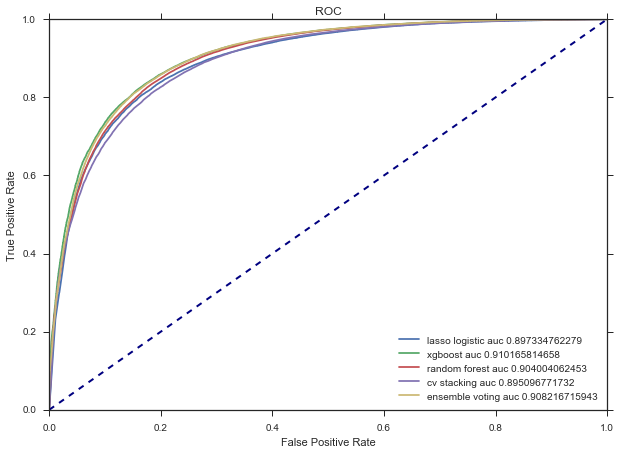

In [125]:
f = plt.figure(figsize=(10, 7))
# plot TPR against FPR
for lb, roc_data in roc_dict.iteritems():
    fpr = roc_data['fpr']
    tpr = roc_data['tpr']
    auc = roc_data['auc']
    plt.plot(fpr, tpr, label=lb +' auc '+str(auc))

# plot 45 degree line
xx = np.linspace(0, 1.0, 20)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()
f.savefig("../demo_day/roc.png")